## 1. Load Packages and Dataset

In [2]:
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

df = pd.read_csv('cleaned_retail_dataset.csv')

## 2. Two LGBM models for Sperapte Product Category(Weekly)

#### We observed that the majority of products have stock codes that either start with 2 or another number. We suspect that this difference could be due to variations in product type or the platform on which they are sold, which could lead to differences in trends, seasonality, and other factors. Therefore, we first want to train separate LGBM models for each group.

In [5]:
df['StockCode_Flag'] = df['StockCode'].astype(str).str.startswith('2').astype(int)
df_flag_1 = df[df['StockCode_Flag'] == 1]
df_flag_0 = df[df['StockCode_Flag'] == 0]

#### The data is therefore split into two categories: Group 1, which contains products with stock codes starting with 2, and Group 0, which contains all other products. The data is then aggregated into weekly sales data to avoid too much fluctuations and noise. We also filled the value at week with 0 number of sales by average value from its neighbor, so that we can later properly compute MAPE to evaluate performance.

In [7]:
def fill_with_neighbors_mean(df):
    df = df.copy()
    for i in range(1, len(df) - 1): 
        if df.loc[i, 'Sales'] == 0:
            prev_val = df.loc[i - 1, 'Sales']
            next_val = df.loc[i + 1, 'Sales']
            df.loc[i, 'Sales'] = (prev_val + next_val) / 2
    return df

df_flag_1 = df_flag_1.copy()
df_flag_1['InvoiceDate'] = pd.to_datetime(df_flag_1['InvoiceDate'])
df_flag_1.set_index('InvoiceDate', inplace=True)

weekly_sales = df_flag_1['Sales'].resample('W').sum()
weekly_sales_df_1 = weekly_sales.reset_index()
weekly_sales_df_1 = fill_with_neighbors_mean(weekly_sales_df_1)

df_flag_0 = df_flag_0.copy()
df_flag_0['InvoiceDate'] = pd.to_datetime(df_flag_0['InvoiceDate'])
df_flag_0.set_index('InvoiceDate', inplace=True)

weekly_sales = df_flag_0['Sales'].resample('W').sum()
weekly_sales_df_0 = weekly_sales.reset_index()
weekly_sales_df_0 = fill_with_neighbors_mean(weekly_sales_df_0)

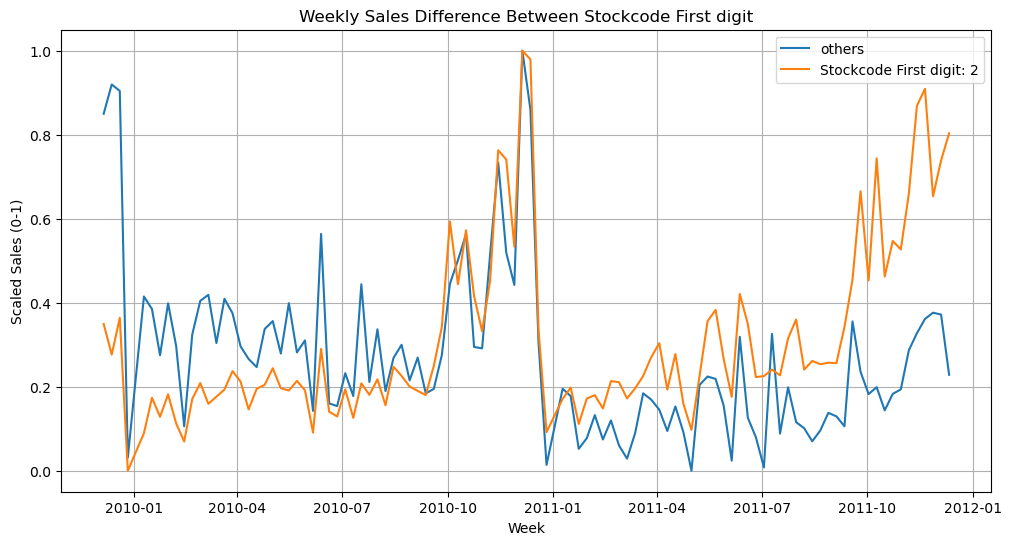

In [8]:
scaler = MinMaxScaler()

weekly_sales_df_0['Sales_scaled'] = scaler.fit_transform(weekly_sales_df_0[['Sales']])
weekly_sales_df_1['Sales_scaled'] = scaler.fit_transform(weekly_sales_df_1[['Sales']])

plt.figure(figsize=(12, 6))
plt.plot(weekly_sales_df_0['InvoiceDate'], weekly_sales_df_0['Sales_scaled'], label='others')
plt.plot(weekly_sales_df_1['InvoiceDate'], weekly_sales_df_1['Sales_scaled'], label='Stockcode First digit: 2')

plt.xlabel('Week')
plt.ylabel('Scaled Sales (0-1)')
plt.title('Weekly Sales Difference Between Stockcode First digit')
plt.legend()
plt.grid(True)
plt.show()

#### From the above plot, we can observe that products in Group 1 and Group 0 share a similar overall trend. However, products in Group 1 show a noticeably stronger upward trend in sales compared to those in Group 0. Our expectation is that by training separate models, we can better capture the distinct characteristics of each time series.

### 2.1 Model Training for Group 1(stockcode start with 2) Data

Best Hyperparameters: {'n_estimators': 50, 'learning_rate': 0.05, 'max_depth': 3, 'num_leaves': 2}


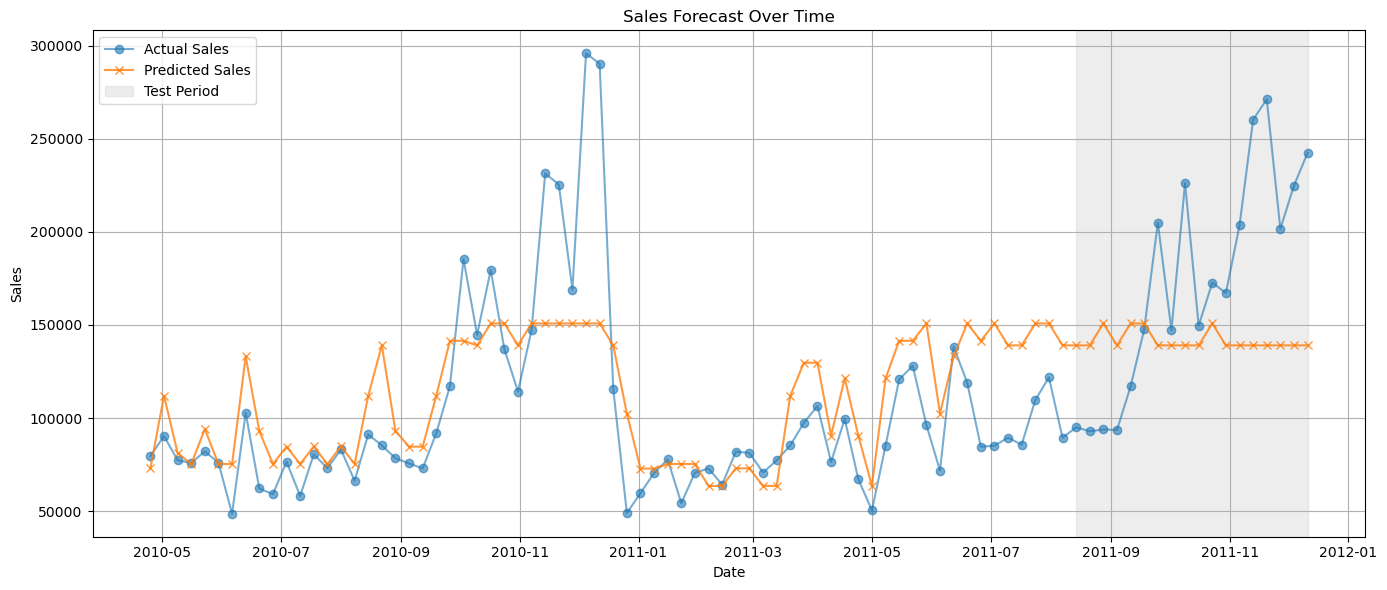

In [11]:
import warnings
warnings.filterwarnings('ignore')

df = weekly_sales_df_1.copy()
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df = df.sort_values('InvoiceDate')
df = df.set_index('InvoiceDate')

for lag in [1, 3, 5, 10, 20]:
    df[f'lag_{lag}'] = df['Sales'].shift(lag)

df.dropna(inplace=True)

n = len(df)
train_end = int(n * 0.6)
val_end = int(n * 0.80)

train = df.iloc[:train_end]
val = df.iloc[train_end:val_end]
test = df.iloc[val_end:]

X_train = train.drop('Sales', axis=1)
y_train = train['Sales']
X_val = val.drop('Sales', axis=1)
y_val = val['Sales']
X_test_1 = test.drop('Sales', axis=1)
y_test_1 = test['Sales']

param_grid = {
    'n_estimators': [50, 100, 150, 300],
    'learning_rate': [0.05, 0.075, 0.1],
    'max_depth': [3, 5, 10, 15],
    'num_leaves': [2, 5, 10, 30]
}

best_score = float('inf')
best_params = None
best_model_1 = None

for n_est in param_grid['n_estimators']:
    for lr in param_grid['learning_rate']:
        for md in param_grid['max_depth']:
            for nl in param_grid['num_leaves']:
                model = LGBMRegressor(
                    verbosity = -1, 
                    n_estimators=n_est,
                    learning_rate=lr,
                    max_depth=md,
                    num_leaves=nl,
                )
                model.fit(X_train, y_train)
                val_pred = model.predict(X_val)
                score = np.sqrt(mean_squared_error(y_val, val_pred))
                
                if score < best_score:
                    best_score = score
                    best_params = {
                        'n_estimators': n_est,
                        'learning_rate': lr,
                        'max_depth': md,
                        'num_leaves': nl
                    }
                    best_model_1 = model

print("Best Hyperparameters:", best_params)

df_features = df.drop('Sales', axis=1)
flag_1_predict_sales = best_model_1.predict(df_features)
true_sales_1 = df['Sales']

plt.figure(figsize=(14, 6))
plt.plot(df.index, df['Sales'], label='Actual Sales', marker='o', alpha=0.6)
plt.plot(df.index, flag_1_predict_sales, label='Predicted Sales', marker='x', alpha=0.8)

plt.axvspan(df.index[val_end], df.index[-1], color='lightgrey', alpha=0.4, label='Test Period')
plt.title('Sales Forecast Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Overall MAPE for Test Period 1: 18.35%
Overall MAPE for Test Period 2: 26.11%
Overall MAPE for Test Period 3: 37.15%


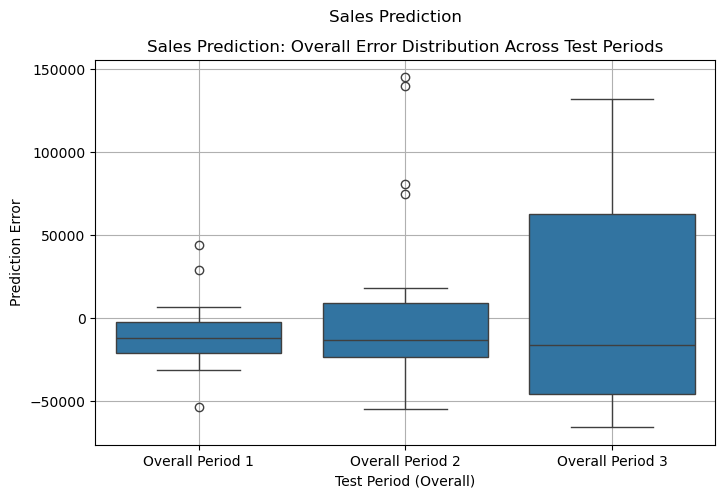

In [12]:
def my_mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def three_split_plot(total_true_test, total_test_predict, subtitle=""):
    total_test_predict = pd.Series(total_test_predict, index=total_true_test.index)
    test_split = np.array_split(total_true_test.index, 3)

    mape_results = []

    for i, period in enumerate(test_split):
        mape_period = my_mape(total_true_test.loc[period], total_test_predict.loc[period])
        mape_results.append(mape_period)
        print(f"Overall MAPE for Test Period {i+1}: {mape_period:.2f}%")

    error_df = []
    for i, period in enumerate(test_split):
        period_error = total_true_test.loc[period] - total_test_predict.loc[period]
        error_df.append(pd.DataFrame({'Error': period_error, 'Test Period': f"Overall Period {i+1}"}))

    error_df = pd.concat(error_df)

    plt.figure(figsize=(8,5))
    if subtitle:
        plt.suptitle(subtitle, fontsize=12)
    sns.boxplot(x="Test Period", y="Error", data=error_df)
    plt.title(subtitle + ": Overall Error Distribution Across Test Periods")
    plt.xlabel("Test Period (Overall)")
    plt.ylabel("Prediction Error")
    plt.grid()
    plt.show()
three_split_plot(df['Sales'], flag_1_predict_sales, 'Sales Prediction')

### 2.2 Model Training for Group 0(stockcode not start with 2) Data

Best Hyperparameters: {'n_estimators': 300, 'learning_rate': 0.075, 'max_depth': 3, 'num_leaves': 2}


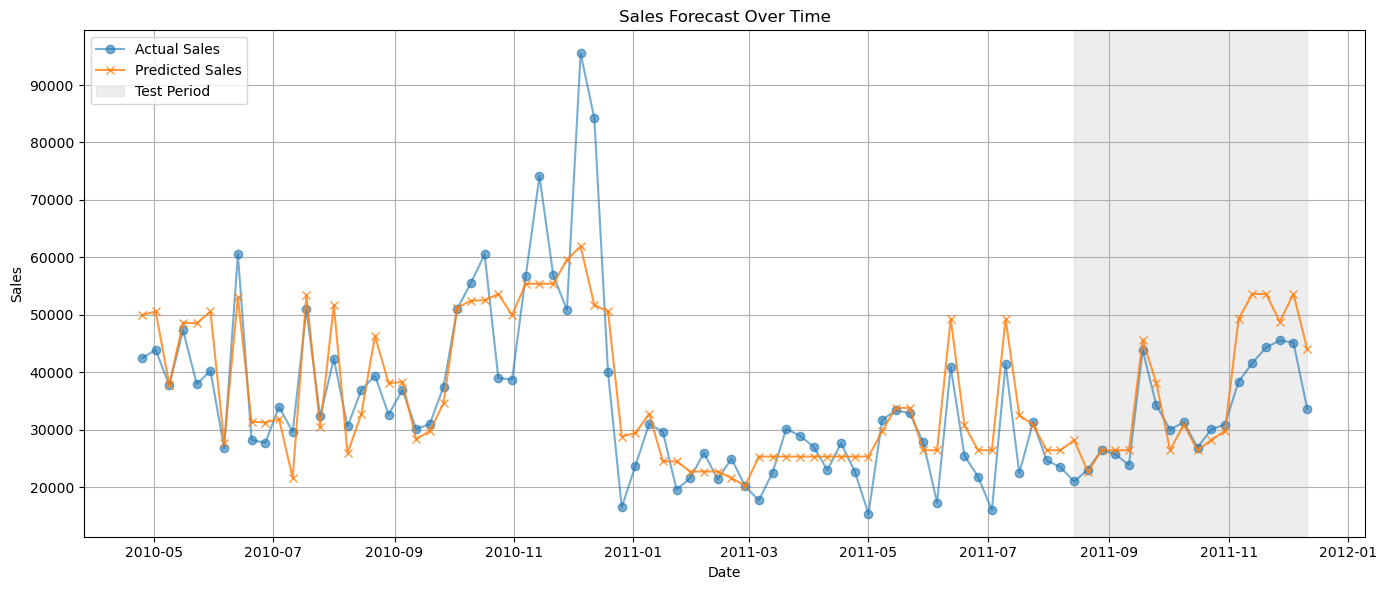

In [14]:
warnings.filterwarnings('ignore')
df = weekly_sales_df_0.copy()
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df = df.sort_values('InvoiceDate')
df = df.set_index('InvoiceDate')

for lag in [1, 3, 5, 10, 20]:
    df[f'lag_{lag}'] = df['Sales'].shift(lag)


df.dropna(inplace=True)

n = len(df)
train_end = int(n * 0.6)
val_end = int(n * 0.80)

train = df.iloc[:train_end]
val = df.iloc[train_end:val_end]
test = df.iloc[val_end:]

X_train = train.drop('Sales', axis=1)
y_train = train['Sales']
X_val = val.drop('Sales', axis=1)
y_val = val['Sales']
X_test_0 = test.drop('Sales', axis=1)
y_test_0 = test['Sales']

param_grid = {
    'n_estimators': [50, 100, 150, 300],
    'learning_rate': [0.05, 0.075, 0.1],
    'max_depth': [3, 5, 10, 15],
    'num_leaves': [2, 5, 10, 30]
}

best_score = float('inf')
best_params = None
best_model_0 = None

for n_est in param_grid['n_estimators']:
    for lr in param_grid['learning_rate']:
        for md in param_grid['max_depth']:
            for nl in param_grid['num_leaves']:
                model = LGBMRegressor(
                    verbosity = -1, 
                    n_estimators=n_est,
                    learning_rate=lr,
                    max_depth=md,
                    num_leaves=nl,
                    random_state=42
                )
                model.fit(X_train, y_train)
                val_pred = model.predict(X_val)
                score = np.sqrt(mean_squared_error(y_val, val_pred))
                
                if score < best_score:
                    best_score = score
                    best_params = {
                        'n_estimators': n_est,
                        'learning_rate': lr,
                        'max_depth': md,
                        'num_leaves': nl
                    }
                    best_model_0 = model

print("Best Hyperparameters:", best_params)

df_features = df.drop('Sales', axis=1)
flag_0_predict_sales = best_model_0.predict(df_features)
true_sales_0 = df['Sales']

plt.figure(figsize=(14, 6))
plt.plot(df.index, df['Sales'], label='Actual Sales', marker='o', alpha=0.6)
plt.plot(df.index, flag_0_predict_sales, label='Predicted Sales', marker='x', alpha=0.8)

plt.axvspan(df.index[val_end], df.index[-1], color='lightgrey', alpha=0.4, label='Test Period')

plt.title('Sales Forecast Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



Overall MAPE for Test Period 1: 12.61%
Overall MAPE for Test Period 2: 18.31%
Overall MAPE for Test Period 3: 17.49%


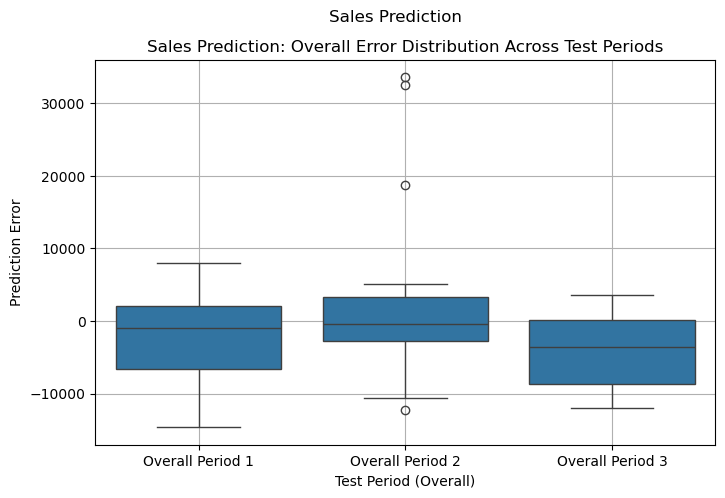

In [15]:
three_split_plot(df['Sales'], flag_0_predict_sales, 'Sales Prediction')

### 2.3 Combined LGBM Performance

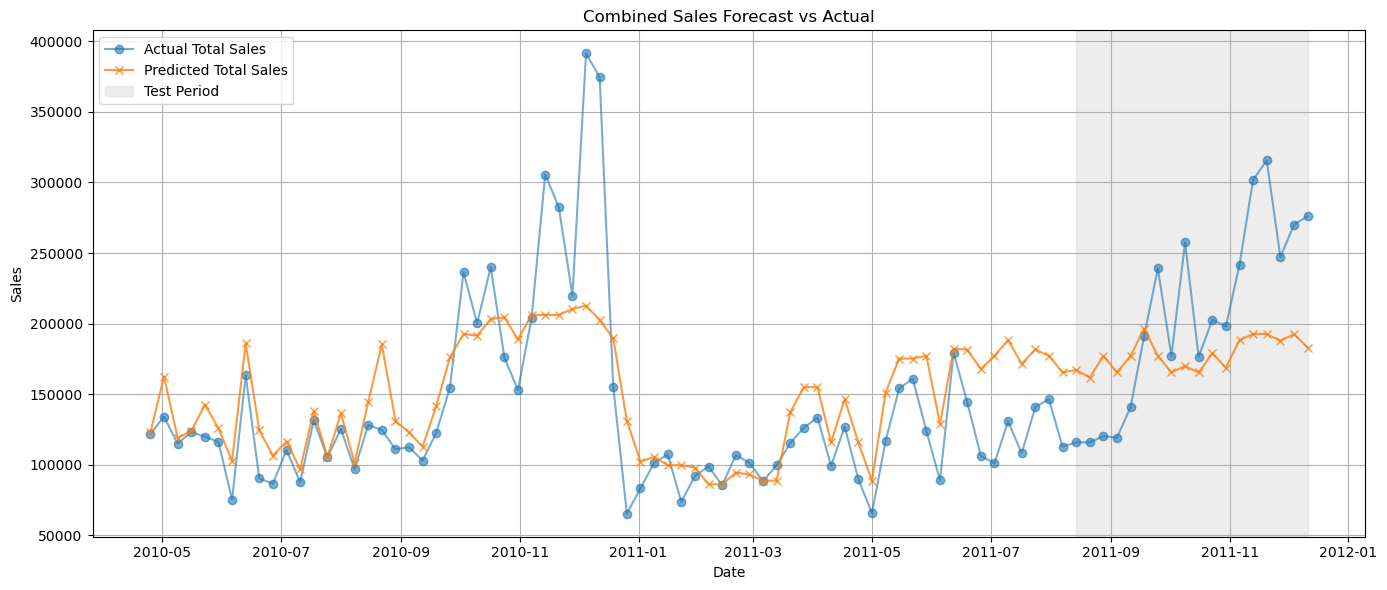

In [17]:
Total_Predicted = flag_1_predict_sales + flag_0_predict_sales
Total_true = true_sales_0 + true_sales_1

plt.figure(figsize=(14, 6))
plt.plot(df.index, Total_true, label='Actual Total Sales', marker='o', alpha=0.6)
plt.plot(df.index, Total_Predicted, label='Predicted Total Sales', marker='x', alpha=0.8)

plt.axvspan(df.index[val_end], df.index[-1], color='lightgrey', alpha=0.4, label='Test Period')

plt.title('Combined Sales Forecast vs Actual')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
test_predict_0 = best_model_0.predict(X_test_0)
test_predict_1 = best_model_1.predict(X_test_1)

total_test_predict = test_predict_0 + test_predict_1
total_true_test = y_test_0 + y_test_1

mape = np.mean(np.abs((total_true_test - total_test_predict) / total_true_test)) * 100
mape

26.71967716096859

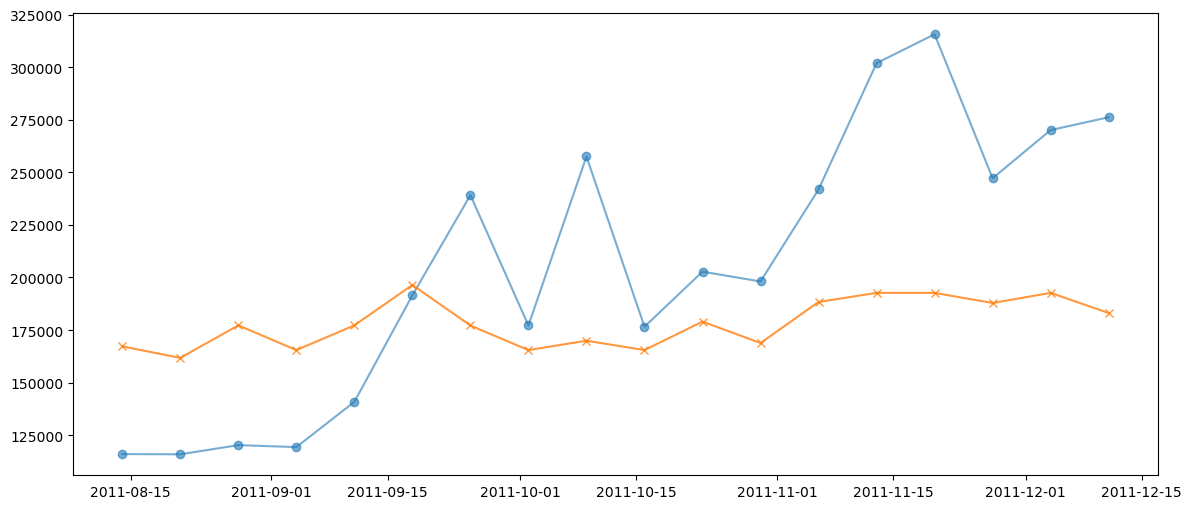

In [19]:
plt.figure(figsize=(14, 6))
plt.plot(total_true_test.index, total_true_test, label='Actual Total Sales', marker='o', alpha=0.6)
plt.plot(total_true_test.index, total_test_predict, label='Predicted Total Sales', marker='x', alpha=0.8)

Overall MAPE for Test Period 1: 33.01%
Overall MAPE for Test Period 2: 16.55%
Overall MAPE for Test Period 3: 30.60%


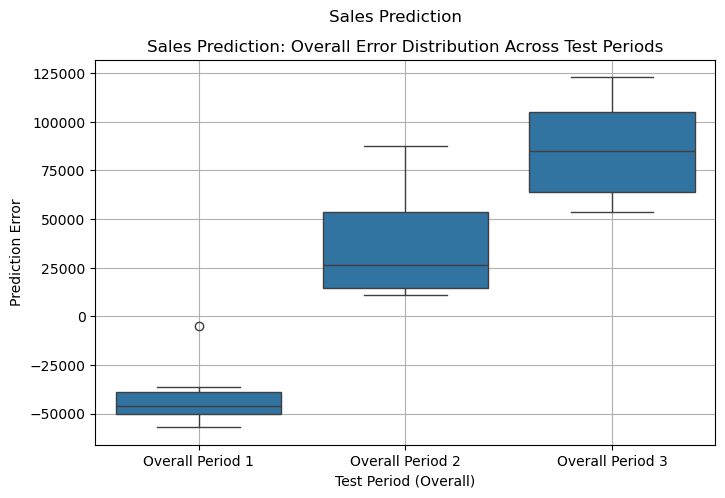

In [20]:
three_split_plot(total_true_test, total_test_predict, 'Sales Prediction')

## 3. One LGBM model for Entire Data

Best Hyperparameters: {'n_estimators': 50, 'learning_rate': 0.05, 'max_depth': 3, 'num_leaves': 2}


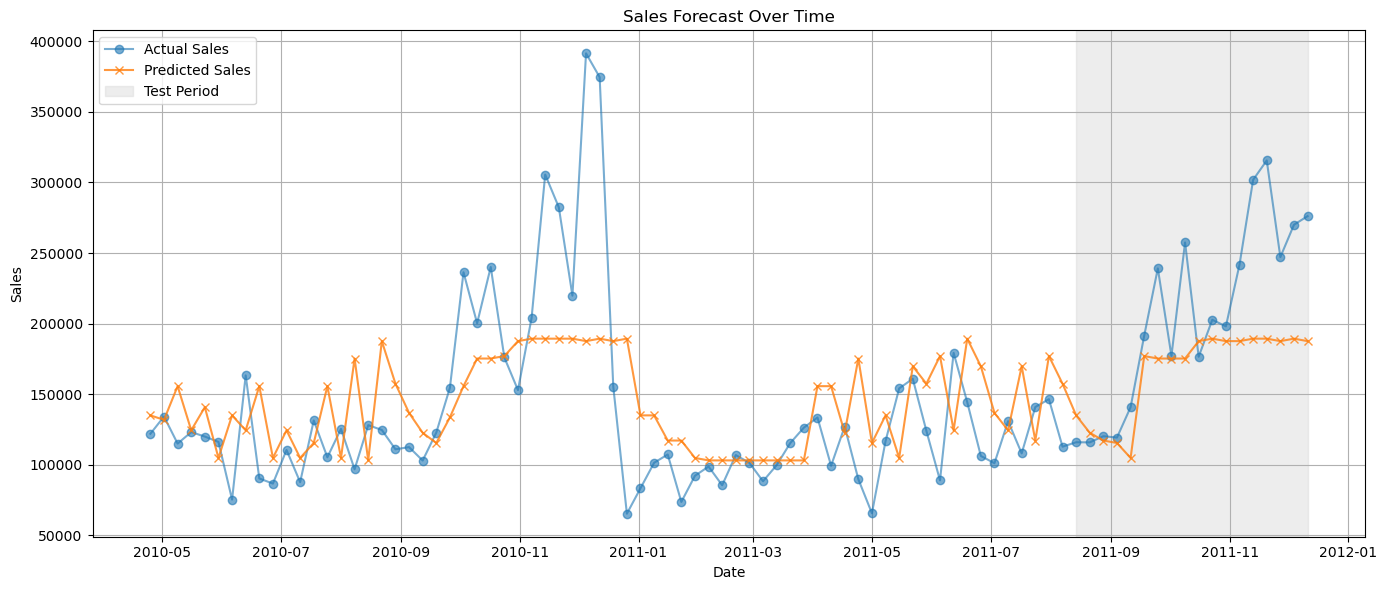

18.033564537423967

In [22]:
df = pd.read_csv('cleaned_retail_dataset.csv')
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df.set_index('InvoiceDate', inplace=True)
weekly_sales = df['Sales'].resample('W').sum()
weekly_sales = weekly_sales.reset_index()
weekly_sales = fill_with_neighbors_mean(weekly_sales)

df = weekly_sales.copy()
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df = df.sort_values('InvoiceDate')
df = df.set_index('InvoiceDate')

for lag in [1, 3, 5, 10, 20]:
    df[f'lag_{lag}'] = df['Sales'].shift(lag)


df.dropna(inplace=True)

n = len(df)
train_end = int(n * 0.6)
val_end = int(n * 0.80)

train = df.iloc[:train_end]
val = df.iloc[train_end:val_end]
test = df.iloc[val_end:]

X_train = train.drop('Sales', axis=1)
y_train = train['Sales']
X_val = val.drop('Sales', axis=1)
y_val = val['Sales']
X_test_1 = test.drop('Sales', axis=1)
y_test_1 = test['Sales']

param_grid = {
    'n_estimators': [50, 100, 150, 300],
    'learning_rate': [0.05, 0.075, 0.1],
    'max_depth': [3, 5, 10, 15],
    'num_leaves': [2, 5, 10, 30]
}

best_score = float('inf')
best_params = None
best_model_1 = None

for n_est in param_grid['n_estimators']:
    for lr in param_grid['learning_rate']:
        for md in param_grid['max_depth']:
            for nl in param_grid['num_leaves']:
                model = LGBMRegressor(
                    verbosity = -1, 
                    n_estimators=n_est,
                    learning_rate=lr,
                    max_depth=md,
                    num_leaves=nl,
                )
                model.fit(X_train, y_train)
                val_pred = model.predict(X_val)
                score = np.sqrt(mean_squared_error(y_val, val_pred))
                
                if score < best_score:
                    best_score = score
                    best_params = {
                        'n_estimators': n_est,
                        'learning_rate': lr,
                        'max_depth': md,
                        'num_leaves': nl
                    }
                    best_model_1 = model

print("Best Hyperparameters:", best_params)

df_features = df.drop('Sales', axis=1)
flag_1_predict_sales = best_model_1.predict(df_features)
true_sales = df['Sales']

plt.figure(figsize=(14, 6))
plt.plot(df.index, df['Sales'], label='Actual Sales', marker='o', alpha=0.6)
plt.plot(df.index, flag_1_predict_sales, label='Predicted Sales', marker='x', alpha=0.8)

plt.axvspan(df.index[val_end], df.index[-1], color='lightgrey', alpha=0.4, label='Test Period')

plt.title('Sales Forecast Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

test_predict_1 = best_model_1.predict(X_test_1)

total_test_predict = test_predict_1
total_true_test = y_test_1

mape = np.mean(np.abs((total_true_test - total_test_predict) / total_true_test)) * 100
mape

Overall MAPE for Test Period 1: 10.19%
Overall MAPE for Test Period 2: 12.97%
Overall MAPE for Test Period 3: 30.95%


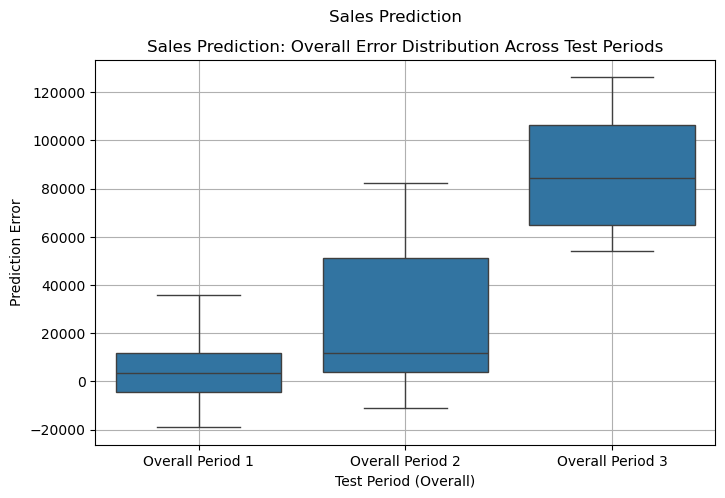

In [23]:
three_split_plot(total_true_test, total_test_predict, 'Sales Prediction')